In [1]:
import numpy as np # type: ignore
import random
import matplotlib.pyplot as plt # type: ignore

In [2]:
import csv
import time

In [3]:
import plotly.graph_objects as go
import plotly.io as pio

# Set Plotly to use the dark theme
pio.templates.default = "plotly_dark"

In [4]:
def fitness_function(x, y):
    return x**2 + y**2

In [5]:
def fitness_function_2(x, y):
    return 100 * (x**2 - y)**2 + (1 - x)**2

In [6]:
def initialize_population(size, x1, y1, x2, y2):
    return [(random.uniform(x1, y1), random.uniform(x2, y2)) for _ in range(size)]

In [7]:
def compute_fitness(population):
    return [fitness_function(x, y) for x, y in population]

In [8]:
def compute_fitness_2(population):
    return [fitness_function_2(x, y) for x, y in population]

In [9]:
def roulette_wheel_selection(population, fitnesses):
    total_fitness = sum(fitnesses)
    selection_probs = [f / total_fitness for f in fitnesses]
    return population[np.random.choice(len(population), p=selection_probs)]

In [10]:
def binary_tournament_selection(population, fitnesses):
    i1, i2 = random.sample(range(len(population)), 2)
    return population[i1] if fitnesses[i1] < fitnesses[i2] else population[i2]

In [11]:
def rank_based_selection(population, fitnesses):
    ranks = np.argsort(np.argsort(fitnesses))
    selection_probs = ranks / sum(ranks)
    return population[np.random.choice(len(population), p=selection_probs)]

In [12]:
def truncation_selection(population, fitnesses, size):
    sorted_pop = [x for _, x in sorted(zip(fitnesses, population))]
    return sorted_pop[:size]

In [13]:
def crossover(parent1, parent2):
    alpha = random.uniform(0, 1)
    child1 = (alpha * parent1[0] + (1 - alpha) * parent2[0], alpha * parent1[1] + (1 - alpha) * parent2[1])
    child2 = ((1 - alpha) * parent1[0] + alpha * parent2[0], (1 - alpha) * parent1[1] + alpha * parent2[1])
    return child1, child2

In [16]:
def mutate(individual):
    if random.random() < 0.1:
        return (individual[0] + random.choice([-0.25, 0.25]), individual[1] + random.choice([-0.25, 0.25]))
    return individual

In [20]:
def genetic_algorithm(generations=40, runs=10, pop_size=10, x1=-5, y1=-5, x2=5, y2=5):
    best_fitness_data = [['Generation'] + [f'Run #{i+1} Best Fit.' for i in range(runs)] + ['Overall Best Fit.']]
    avg_fitness_data = [['Generation'] + [f'Run #{i+1} Avg. Fit.' for i in range(runs)] + ['Overall Avg. Fit.']]
    worst_fitness_data = [['Generation'] + [f'Run #{i+1} Worst Fit.' for i in range(runs)] + ['Overall Worst Fit.']]
    
    for gen in range(generations):
        best_fitness_per_run = []
        avg_fitness_per_run = []
        worst_fitness_per_run = []
        
        for run in range(runs):
            population = initialize_population(pop_size, x1, y1, x2, y2)
            fitnesses = compute_fitness(population)
            
            for _ in range(gen):
                new_population = []
                while len(new_population) < pop_size:
                    p1, p2 = binary_tournament_selection(population, fitnesses), binary_tournament_selection(population, fitnesses)
                    c1, c2 = crossover(p1, p2)
                    new_population.append(mutate(c1))
                    new_population.append(mutate(c2))
                
                fitnesses += compute_fitness(new_population)
                population += new_population
                population = truncation_selection(population, fitnesses, pop_size)
                fitnesses = compute_fitness(population)
            
            best_fitness_per_run.append(min(fitnesses))
            avg_fitness_per_run.append(np.mean(fitnesses))
            worst_fitness_per_run.append(max(fitnesses))
        
        overall_best_fitness = np.min(best_fitness_per_run)
        overall_avg_fitness = np.mean(avg_fitness_per_run)
        overall_worst_fitness = np.max(worst_fitness_per_run)
        
        best_fitness_data.append([gen + 1] + best_fitness_per_run + [overall_best_fitness])
        avg_fitness_data.append([gen + 1] + avg_fitness_per_run + [overall_avg_fitness])
        worst_fitness_data.append([gen + 1] + worst_fitness_per_run + [overall_worst_fitness])
    
    current_time = time.strftime('%Y-%m-%d_%H-%M-%S')
    
    with open(f'best_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(best_fitness_data)
    
    with open(f'avg_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(avg_fitness_data)
    
    with open(f'worst_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(worst_fitness_data)
    
    # fig = go.Figure()
    
    # # Add traces for each run
    # for i in range(1, runs + 1):
    #     fig.add_trace(go.Scatter(
    #         y=[row[i] for row in best_fitness_data[1:]],
    #         mode='lines',
    #         name=f'Run #{i}'
    #     ))
    
    # # Add trace for overall average
    # fig.add_trace(go.Scatter(
    #     y=[row[-1] for row in best_fitness_data[1:]],
    #     mode='lines',
    #     name='Overall Avg.',
    #     line=dict(dash='dash', width=2, color='white')
    # ))
    
    # # Update layout
    # fig.update_layout(
    #     title='Best Fitness over Generations',
    #     xaxis_title='Generation',
    #     yaxis_title='Fitness',
    #     template='plotly_dark',
    #     legend=dict(x=0, y=1)
    # )
    
    # # Save the plot as an image
    # fig.write_image(f'fitness_plot_{current_time}.png')
    
    # # Show the plot
    # fig.show()

    # Create subplots with runs + 1 (extra for overall avg)
    fig, axes = plt.subplots(runs + 1, 1, figsize=(8, (runs + 1) * 3), sharex=True)

    # Plot each run in its own subplot
    for i in range(1, runs + 1):
        ax = axes[i - 1]  # Select subplot for the current run
        ax.plot([row[i] for row in avg_fitness_data[1:]], label=f'Run #{i}')
        ax.legend()
        ax.set_ylabel('Fitness')
        ax.set_title(f'Run #{i}')

    # Plot overall average in the last subplot (runs + 1th)
    overall_ax = axes[-1]  # The last subplot is reserved for the overall average
    overall_ax.plot([row[-1] for row in avg_fitness_data[1:]], label='Overall Avg.', linestyle='dashed', linewidth=2, color='black')
    overall_ax.legend()
    overall_ax.set_ylabel('Fitness')
    overall_ax.set_title('Overall Average Fitness')

    # Set common x-label
    plt.xlabel('Generation')

    # Improve layout
    plt.tight_layout()

    # Save and show the plot
    plt.savefig(f'fitness_plot_{current_time}.png')
    plt.show()

# Tournament-Truncation Eq1

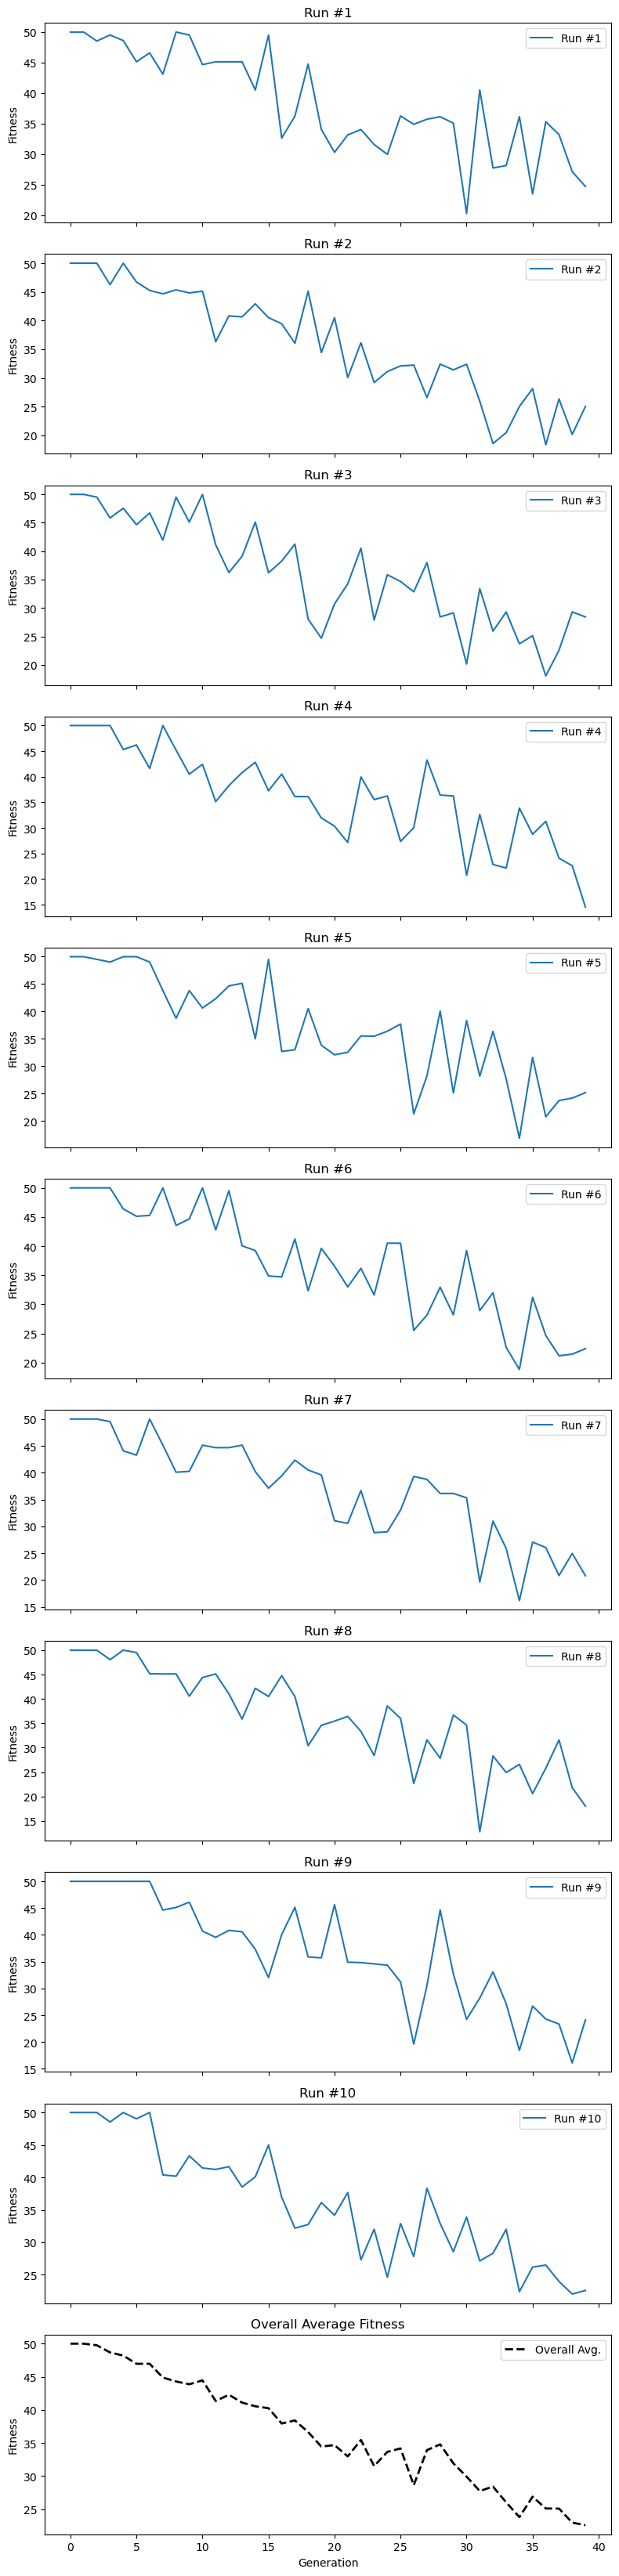

In [21]:
genetic_algorithm()

# Final Geneatic algo for final folders data

In [13]:
def genetic_algorithm(
    generations=40,
    runs=10,
    pop_size=10,
    x1=-5,
    y1=-5,
    x2=5,
    y2=5,
    parent_selection_func=roulette_wheel_selection,
    survival_selection_func=truncation_selection,
):
    best_fitness_data = [['Generation'] + [f'Run #{i+1} Best Fit.' for i in range(runs)] + ['Overall Best Fit.']]
    avg_fitness_data = [['Generation'] + [f'Run #{i+1} Avg. Fit.' for i in range(runs)] + ['Overall Avg. Fit.']]
    worst_fitness_data = [['Generation'] + [f'Run #{i+1} Worst Fit.' for i in range(runs)] + ['Overall Worst Fit.']]
    
    for gen in range(generations):
        best_fitness_per_run = []
        avg_fitness_per_run = []
        worst_fitness_per_run = []
        
        for run in range(runs):
            population = initialize_population(pop_size, x1, y1, x2, y2)
            fitnesses = compute_fitness(population)
            
            for _ in range(gen):
                new_population = []
                while len(new_population) < pop_size:
                    p1 = parent_selection_func(population, fitnesses)
                    p2 = parent_selection_func(population, fitnesses)
                    c1, c2 = crossover(p1, p2)
                    new_population.append(mutate(c1))
                    new_population.append(mutate(c2))
                
                fitnesses += compute_fitness(new_population)
                population += new_population
                population = survival_selection_func(population, fitnesses, pop_size)
                fitnesses = compute_fitness(population)
            
            best_fitness_per_run.append(min(fitnesses))
            avg_fitness_per_run.append(np.mean(fitnesses))
            worst_fitness_per_run.append(max(fitnesses))
        
        overall_best_fitness = np.min(best_fitness_per_run)
        overall_avg_fitness = np.mean(avg_fitness_per_run)
        overall_worst_fitness = np.max(worst_fitness_per_run)
        
        best_fitness_data.append([gen + 1] + best_fitness_per_run + [overall_best_fitness])
        avg_fitness_data.append([gen + 1] + avg_fitness_per_run + [overall_avg_fitness])
        worst_fitness_data.append([gen + 1] + worst_fitness_per_run + [overall_worst_fitness])
    
    current_time = time.strftime('%Y-%m-%d_%H-%M-%S')
    
    with open(f'best_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(best_fitness_data)
    
    with open(f'avg_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(avg_fitness_data)
    
    with open(f'worst_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(worst_fitness_data)
    
    fig, axes = plt.subplots(runs + 1, 1, figsize=(8, (runs + 1) * 3), sharex=True)
    
    for i in range(1, runs + 1):
        ax = axes[i - 1]
        ax.plot([row[i] for row in avg_fitness_data[1:]], label=f'Run #{i}')
        ax.legend()
        ax.set_ylabel('Fitness')
        ax.set_title(f'Run #{i}')
    
    overall_ax = axes[-1]
    overall_ax.plot([row[-1] for row in avg_fitness_data[1:]], label='Overall Avg.', linestyle='dashed', linewidth=2, color='black')
    overall_ax.legend()
    overall_ax.set_ylabel('Fitness')
    overall_ax.set_title('Overall Average Fitness')
    
    plt.xlabel('Generation')
    plt.tight_layout()
    plt.savefig(f'fitness_plot_{current_time}.png')
    plt.show()

# FPS-Truncation

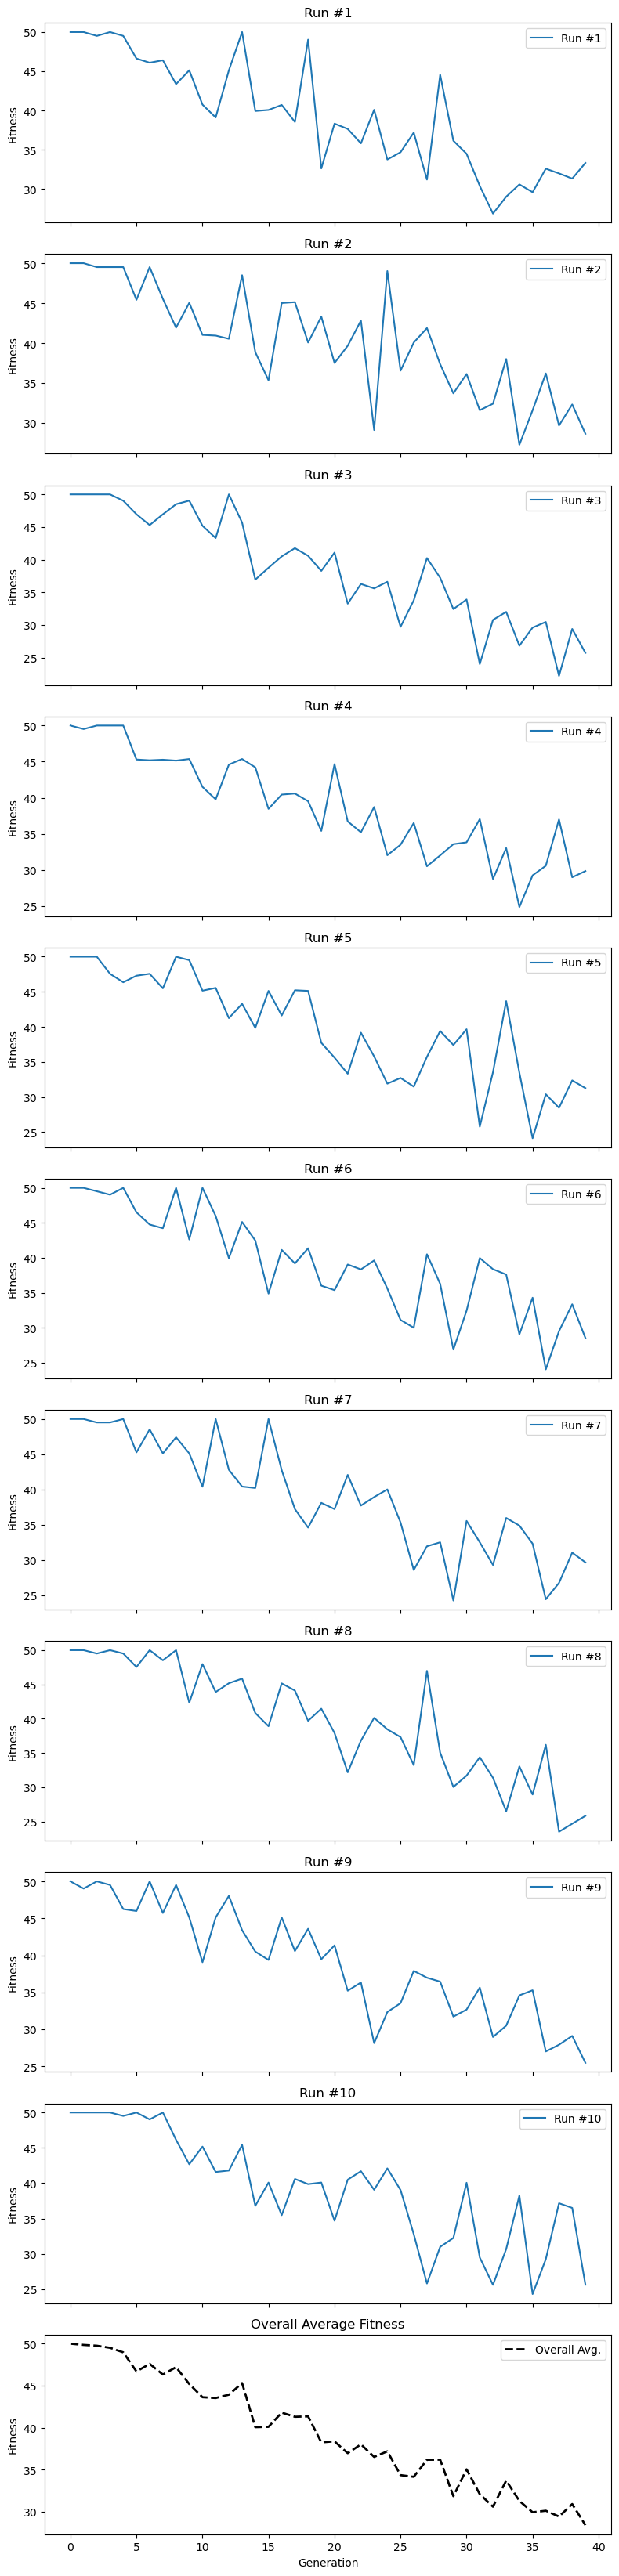

In [30]:
genetic_algorithm()

# RBS-Trunc

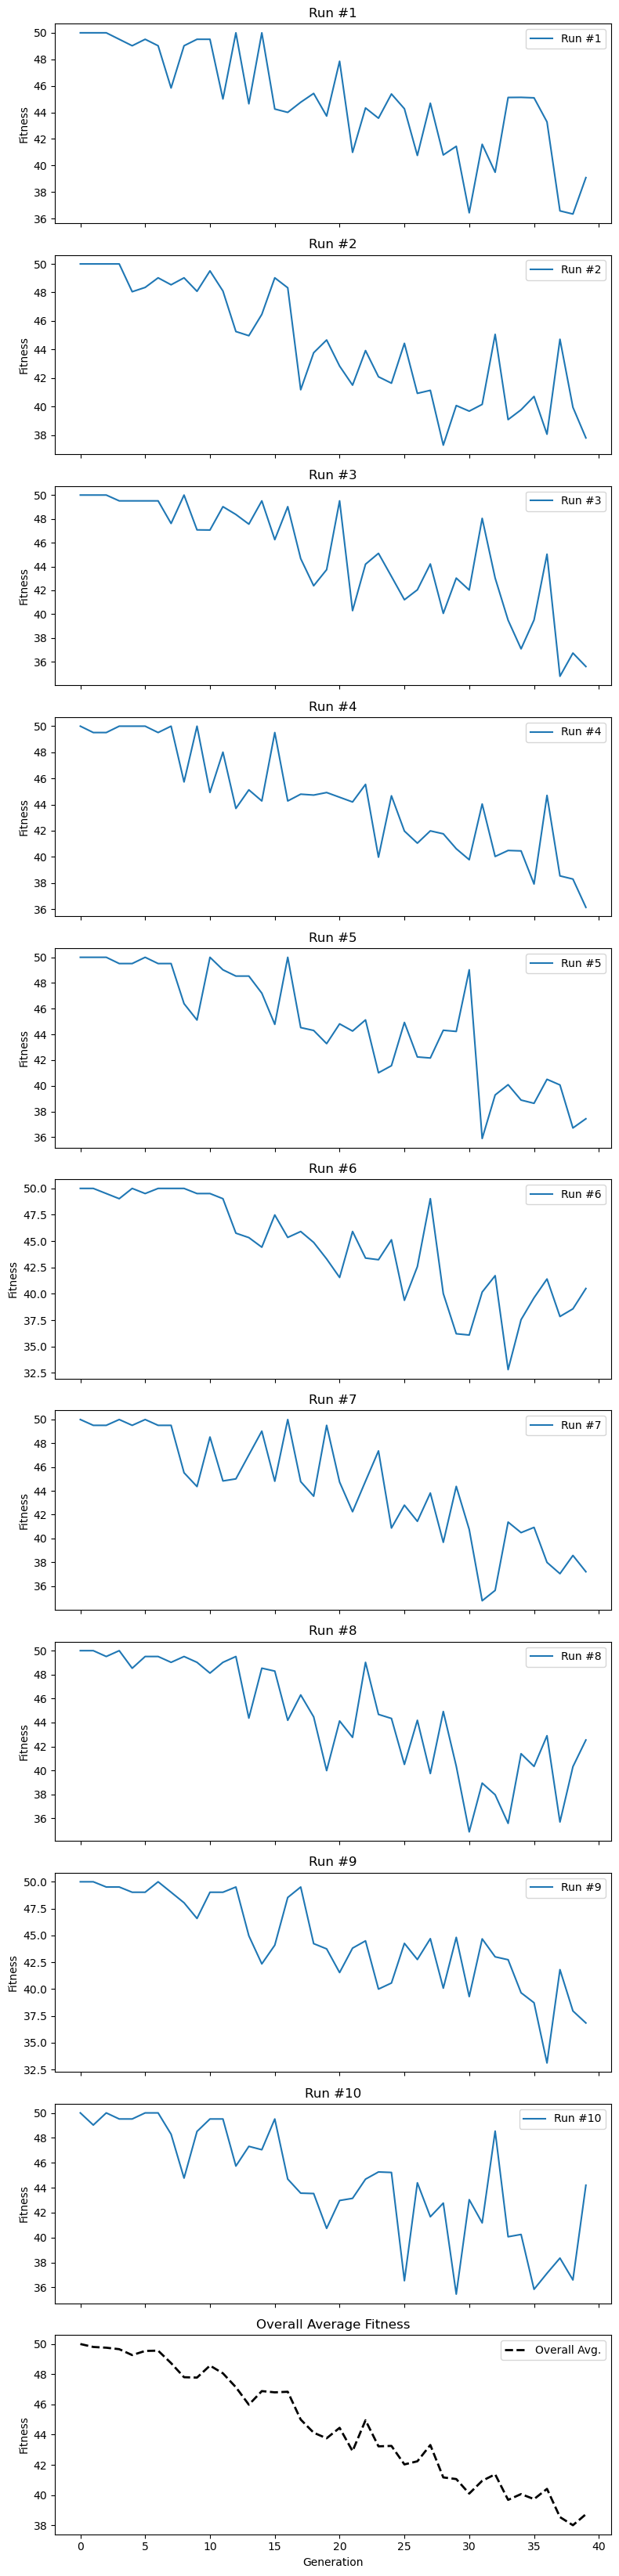

(None,)

In [33]:
genetic_algorithm(parent_selection_func= rank_based_selection,survival_selection_func=truncation_selection),

## Modifying genetic algo for tournament as selection

In [17]:
def tournament_selection_survival(population, fitnesses, pop_size, tournament_size=2):
    """Perform tournament selection to choose the next generation."""
    new_population = []
    for _ in range(pop_size):
        selected_indices = np.random.choice(len(population), tournament_size, replace=False)
        best_index = selected_indices[np.argmin([fitnesses[i] for i in selected_indices])]  # Minimize fitness
        new_population.append(population[best_index])
    return new_population

# FPS- Tour

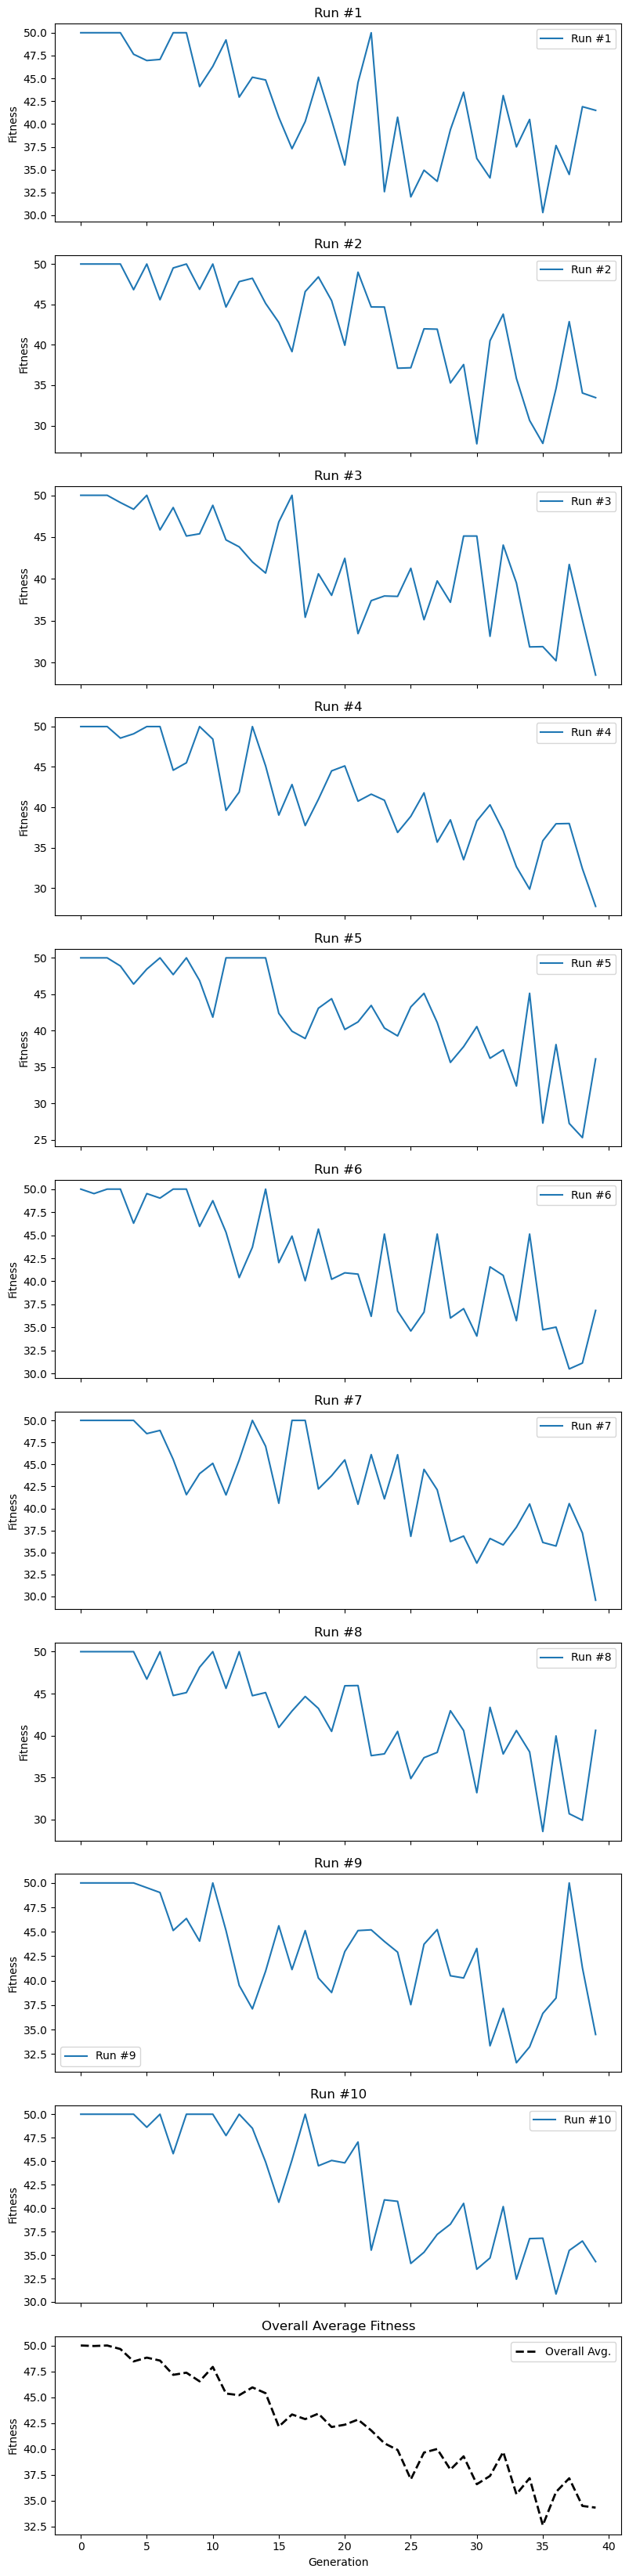

(None,)

In [18]:
genetic_algorithm(parent_selection_func=roulette_wheel_selection, survival_selection_func=tournament_selection_survival),

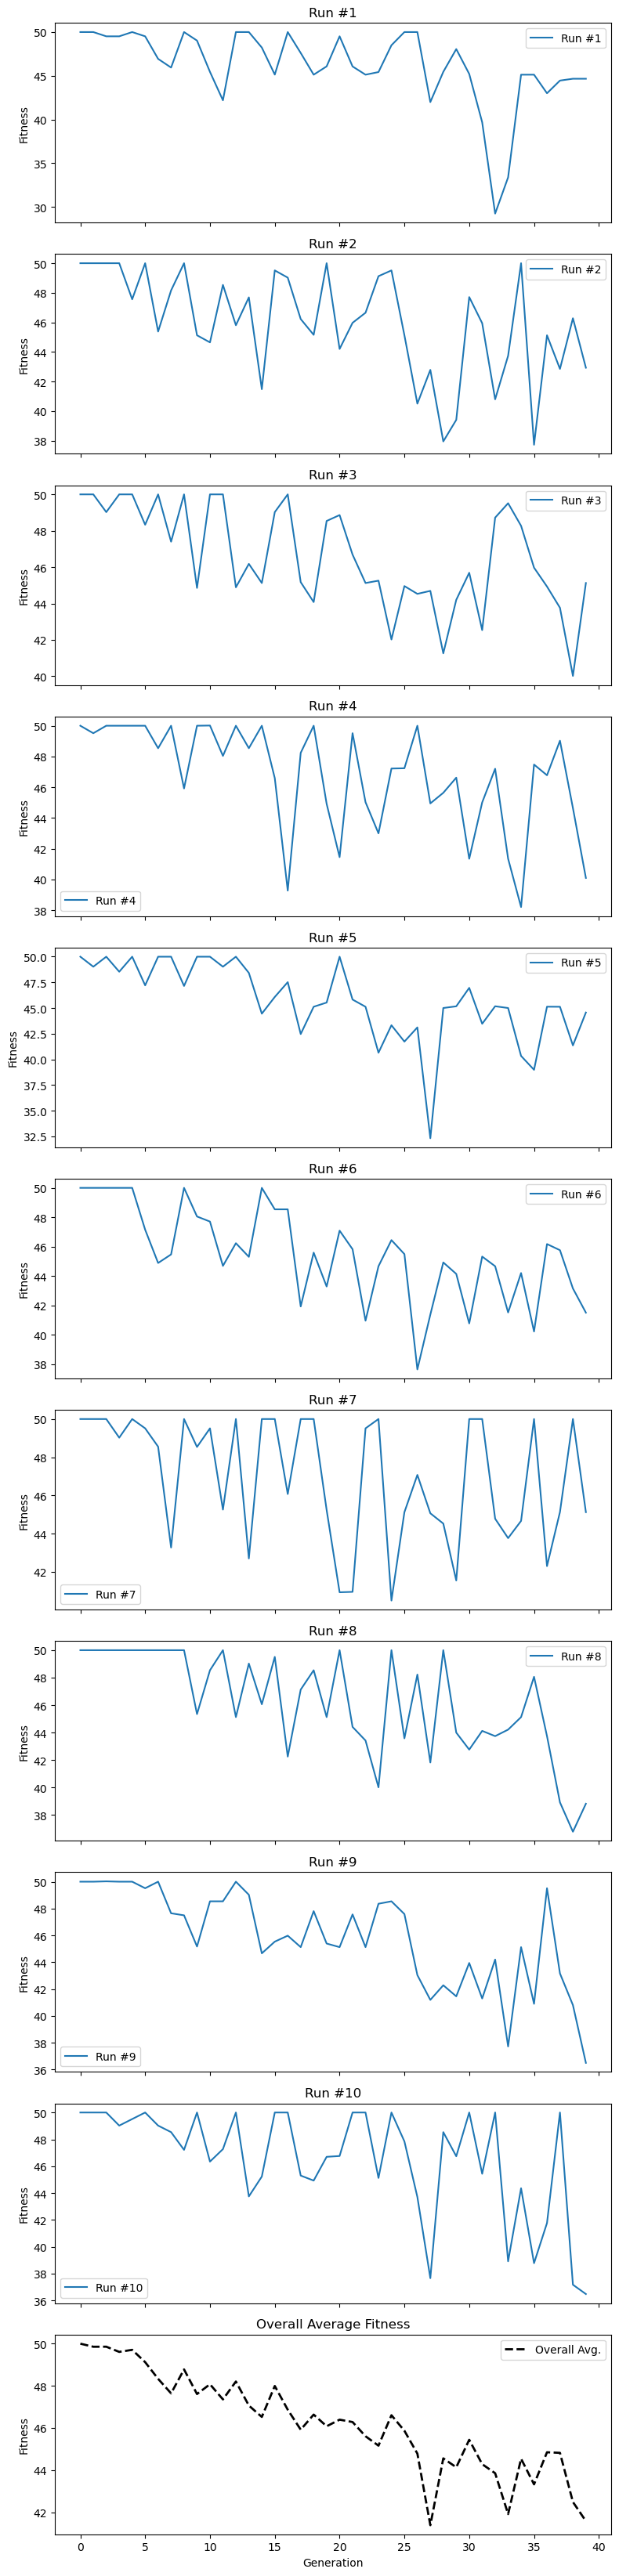

(None,)

In [19]:
genetic_algorithm(parent_selection_func= rank_based_selection,survival_selection_func=tournament_selection_survival),

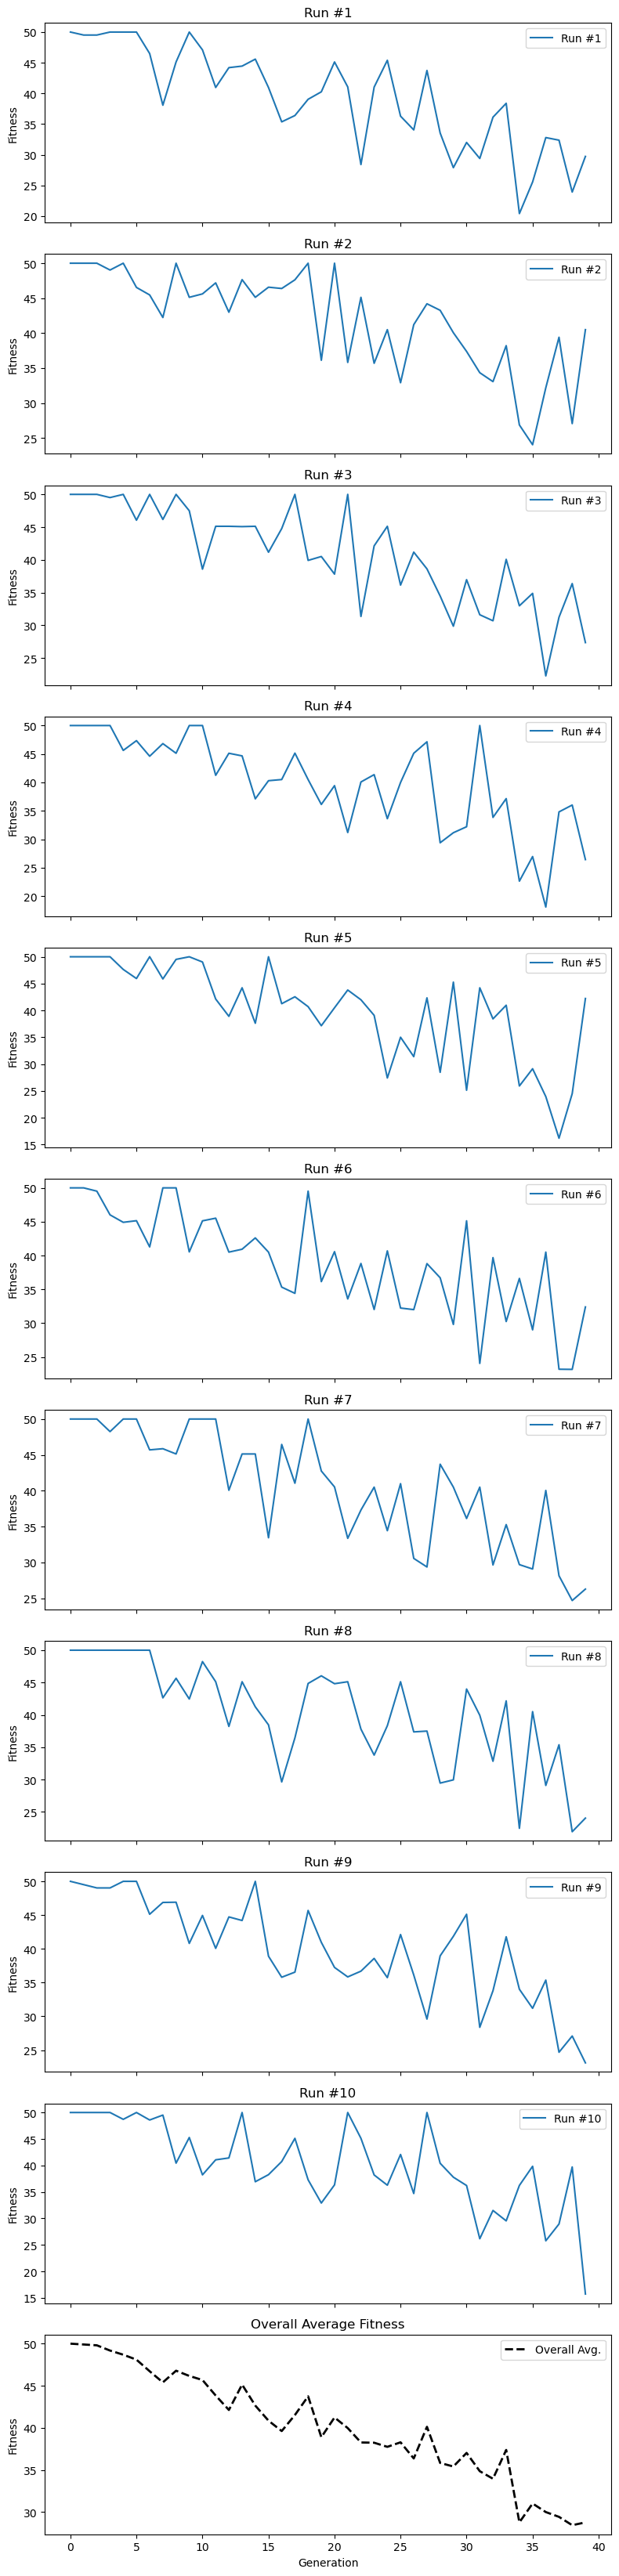

(None,)

In [20]:
genetic_algorithm(parent_selection_func= binary_tournament_selection,survival_selection_func=tournament_selection_survival),

# Equation 2

In [23]:
def genetic_algorithm(
    generations=40,
    runs=10,
    pop_size=10,
    x1=-2,
    y1=-1,
    x2=2,
    y2=3,
    parent_selection_func=roulette_wheel_selection,
    survival_selection_func=truncation_selection,
):
    best_fitness_data = [['Generation'] + [f'Run #{i+1} Best Fit.' for i in range(runs)] + ['Overall Best Fit.']]
    avg_fitness_data = [['Generation'] + [f'Run #{i+1} Avg. Fit.' for i in range(runs)] + ['Overall Avg. Fit.']]
    worst_fitness_data = [['Generation'] + [f'Run #{i+1} Worst Fit.' for i in range(runs)] + ['Overall Worst Fit.']]
    
    for gen in range(generations):
        best_fitness_per_run = []
        avg_fitness_per_run = []
        worst_fitness_per_run = []
        
        for run in range(runs):
            population = initialize_population(pop_size, x1, y1, x2, y2)
            fitnesses = compute_fitness_2(population)
            
            for _ in range(gen):
                new_population = []
                while len(new_population) < pop_size:
                    p1 = parent_selection_func(population, fitnesses)
                    p2 = parent_selection_func(population, fitnesses)
                    c1, c2 = crossover(p1, p2)
                    new_population.append(mutate(c1))
                    new_population.append(mutate(c2))
                
                fitnesses += compute_fitness_2(new_population)
                population += new_population
                population = survival_selection_func(population, fitnesses, pop_size)
                fitnesses = compute_fitness_2(population)
            
            best_fitness_per_run.append(min(fitnesses))
            avg_fitness_per_run.append(np.mean(fitnesses))
            worst_fitness_per_run.append(max(fitnesses))
        
        overall_best_fitness = np.min(best_fitness_per_run)
        overall_avg_fitness = np.mean(avg_fitness_per_run)
        overall_worst_fitness = np.max(worst_fitness_per_run)
        
        best_fitness_data.append([gen + 1] + best_fitness_per_run + [overall_best_fitness])
        avg_fitness_data.append([gen + 1] + avg_fitness_per_run + [overall_avg_fitness])
        worst_fitness_data.append([gen + 1] + worst_fitness_per_run + [overall_worst_fitness])
    
    current_time = time.strftime('%Y-%m-%d_%H-%M-%S')
    
    with open(f'best_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(best_fitness_data)
    
    with open(f'avg_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(avg_fitness_data)
    
    with open(f'worst_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(worst_fitness_data)
    
    fig, axes = plt.subplots(runs + 1, 1, figsize=(8, (runs + 1) * 3), sharex=True)
    
    for i in range(1, runs + 1):
        ax = axes[i - 1]
        ax.plot([row[i] for row in avg_fitness_data[1:]], label=f'Run #{i}')
        ax.legend()
        ax.set_ylabel('Fitness')
        ax.set_title(f'Run #{i}')
    
    overall_ax = axes[-1]
    overall_ax.plot([row[-1] for row in avg_fitness_data[1:]], label='Overall Avg.', linestyle='dashed', linewidth=2, color='black')
    overall_ax.legend()
    overall_ax.set_ylabel('Fitness')
    overall_ax.set_title('Overall Average Fitness')
    
    plt.xlabel('Generation')
    plt.tight_layout()
    plt.savefig(f'fitness_plot_{current_time}.png')
    plt.show()

# Tournament-Truncation Eq2

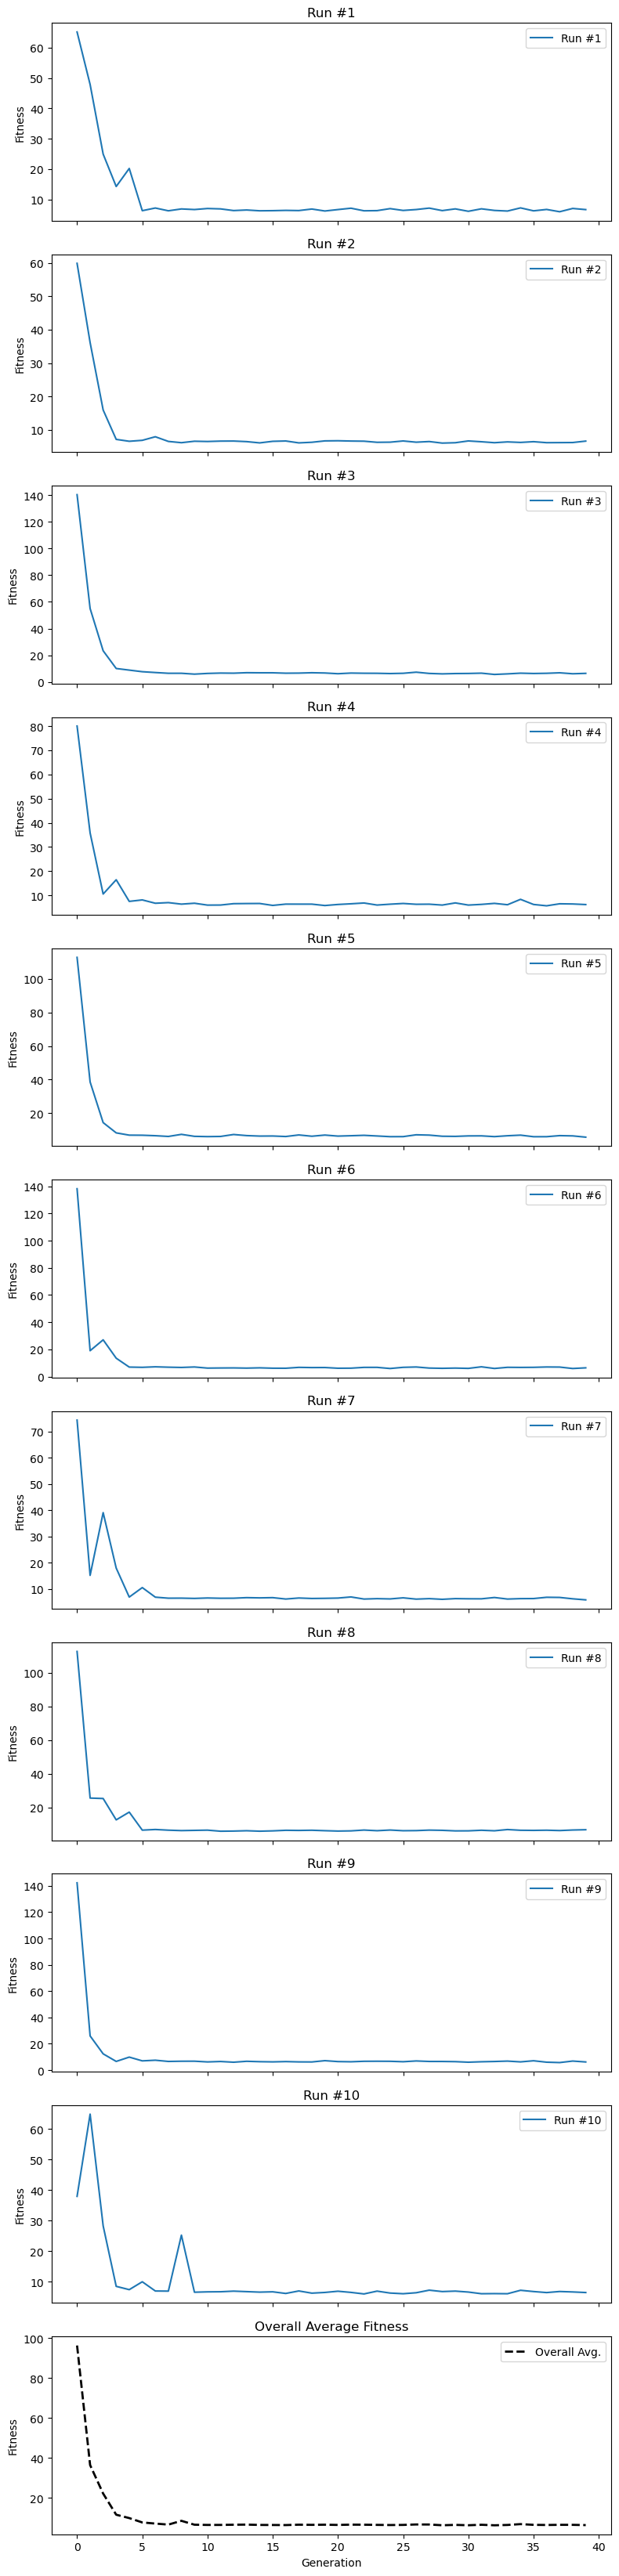

In [26]:
genetic_algorithm()

# Final Geneatic algo for final folders data

In [ ]:
def genetic_algorithm(
    generations=40,
    runs=10,
    pop_size=10,
    x1=-2,
    y1=-1,
    x2=2,
    y2=3,
    parent_selection_func=roulette_wheel_selection,
    survival_selection_func=truncation_selection,
):
    best_fitness_data = [['Generation'] + [f'Run #{i+1} Best Fit.' for i in range(runs)] + ['Overall Best Fit.']]
    avg_fitness_data = [['Generation'] + [f'Run #{i+1} Avg. Fit.' for i in range(runs)] + ['Overall Avg. Fit.']]
    worst_fitness_data = [['Generation'] + [f'Run #{i+1} Worst Fit.' for i in range(runs)] + ['Overall Worst Fit.']]
    
    for gen in range(generations):
        best_fitness_per_run = []
        avg_fitness_per_run = []
        worst_fitness_per_run = []
        
        for run in range(runs):
            population = initialize_population(pop_size, x1, y1, x2, y2)
            fitnesses = compute_fitness_2(population)
            
            for _ in range(gen):
                new_population = []
                while len(new_population) < pop_size:
                    p1 = parent_selection_func(population, fitnesses)
                    p2 = parent_selection_func(population, fitnesses)
                    c1, c2 = crossover(p1, p2)
                    new_population.append(mutate(c1))
                    new_population.append(mutate(c2))
                
                fitnesses += compute_fitness_2(new_population)
                population += new_population
                population = survival_selection_func(population, fitnesses, pop_size)
                fitnesses = compute_fitness_2(population)
            
            best_fitness_per_run.append(min(fitnesses))
            avg_fitness_per_run.append(np.mean(fitnesses))
            worst_fitness_per_run.append(max(fitnesses))
        
        overall_best_fitness = np.min(best_fitness_per_run)
        overall_avg_fitness = np.mean(avg_fitness_per_run)
        overall_worst_fitness = np.max(worst_fitness_per_run)
        
        best_fitness_data.append([gen + 1] + best_fitness_per_run + [overall_best_fitness])
        avg_fitness_data.append([gen + 1] + avg_fitness_per_run + [overall_avg_fitness])
        worst_fitness_data.append([gen + 1] + worst_fitness_per_run + [overall_worst_fitness])
    
    current_time = time.strftime('%Y-%m-%d_%H-%M-%S')
    
    with open(f'best_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(best_fitness_data)
    
    with open(f'avg_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(avg_fitness_data)
    
    with open(f'worst_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(worst_fitness_data)
    
    fig, axes = plt.subplots(runs + 1, 1, figsize=(8, (runs + 1) * 3), sharex=True)
    
    for i in range(1, runs + 1):
        ax = axes[i - 1]
        ax.plot([row[i] for row in avg_fitness_data[1:]], label=f'Run #{i}')
        ax.legend()
        ax.set_ylabel('Fitness')
        ax.set_title(f'Run #{i}')
    
    overall_ax = axes[-1]
    overall_ax.plot([row[-1] for row in avg_fitness_data[1:]], label='Overall Avg.', linestyle='dashed', linewidth=2, color='black')
    overall_ax.legend()
    overall_ax.set_ylabel('Fitness')
    overall_ax.set_title('Overall Average Fitness')
    
    plt.xlabel('Generation')
    plt.tight_layout()
    plt.savefig(f'fitness_plot_{current_time}.png')
    plt.show()

# FPS-Truncation

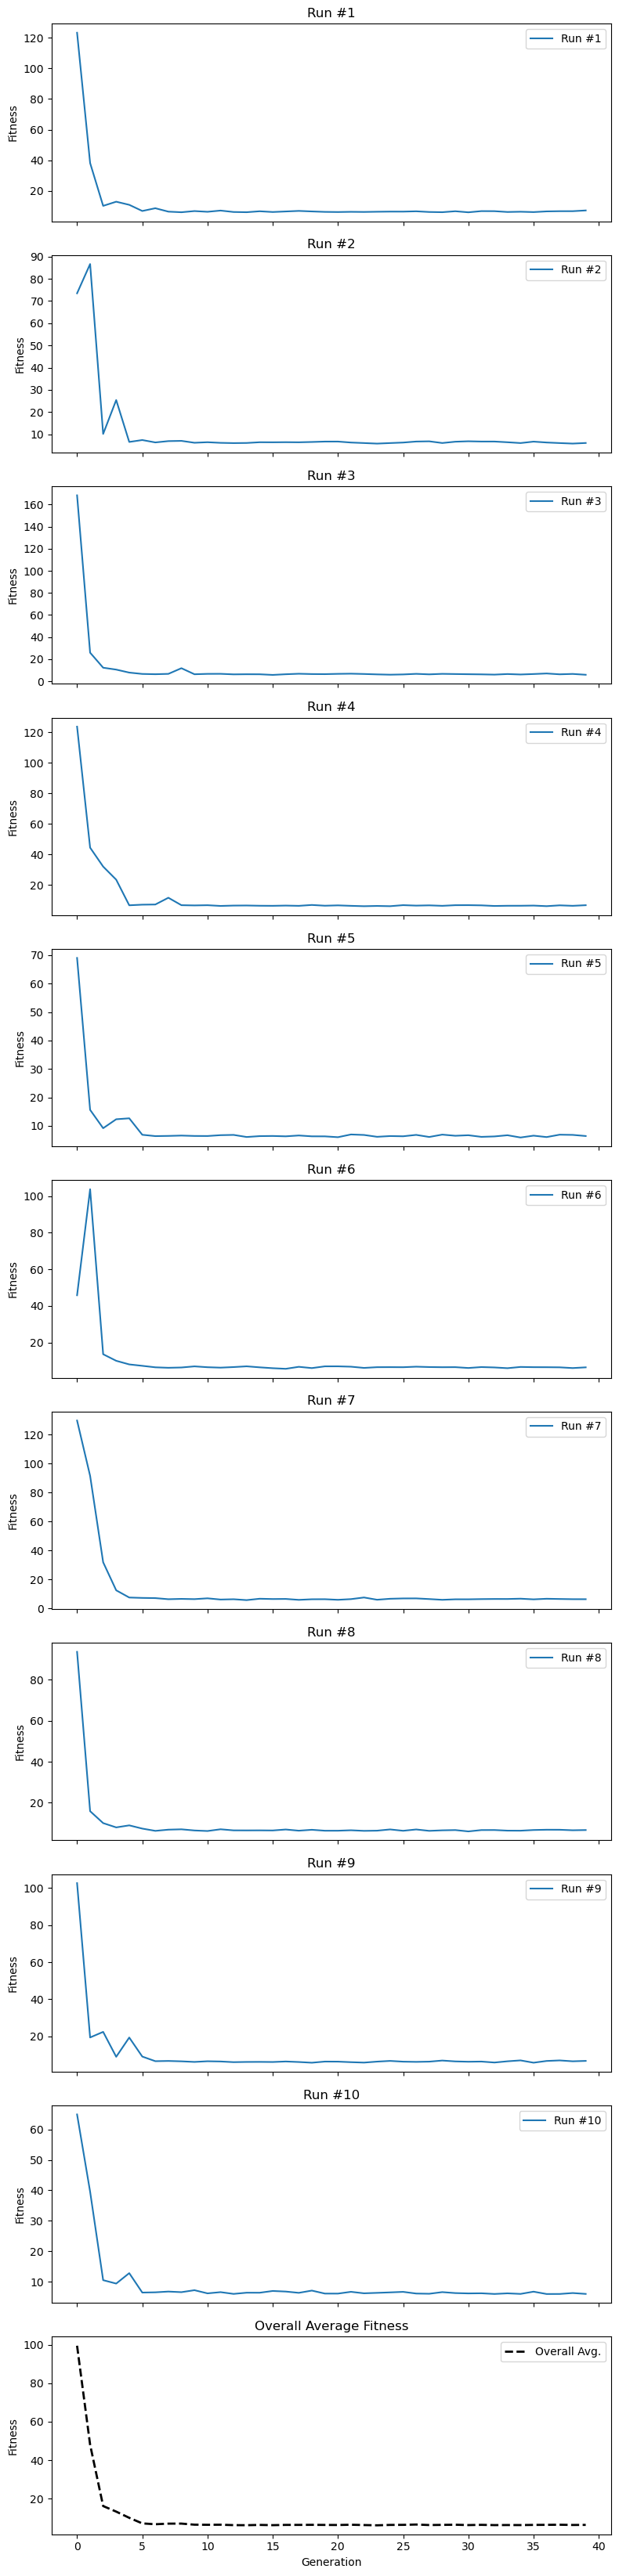

In [27]:
genetic_algorithm(parent_selection_func=roulette_wheel_selection,
    survival_selection_func=truncation_selection,)

# RBS-Trunc

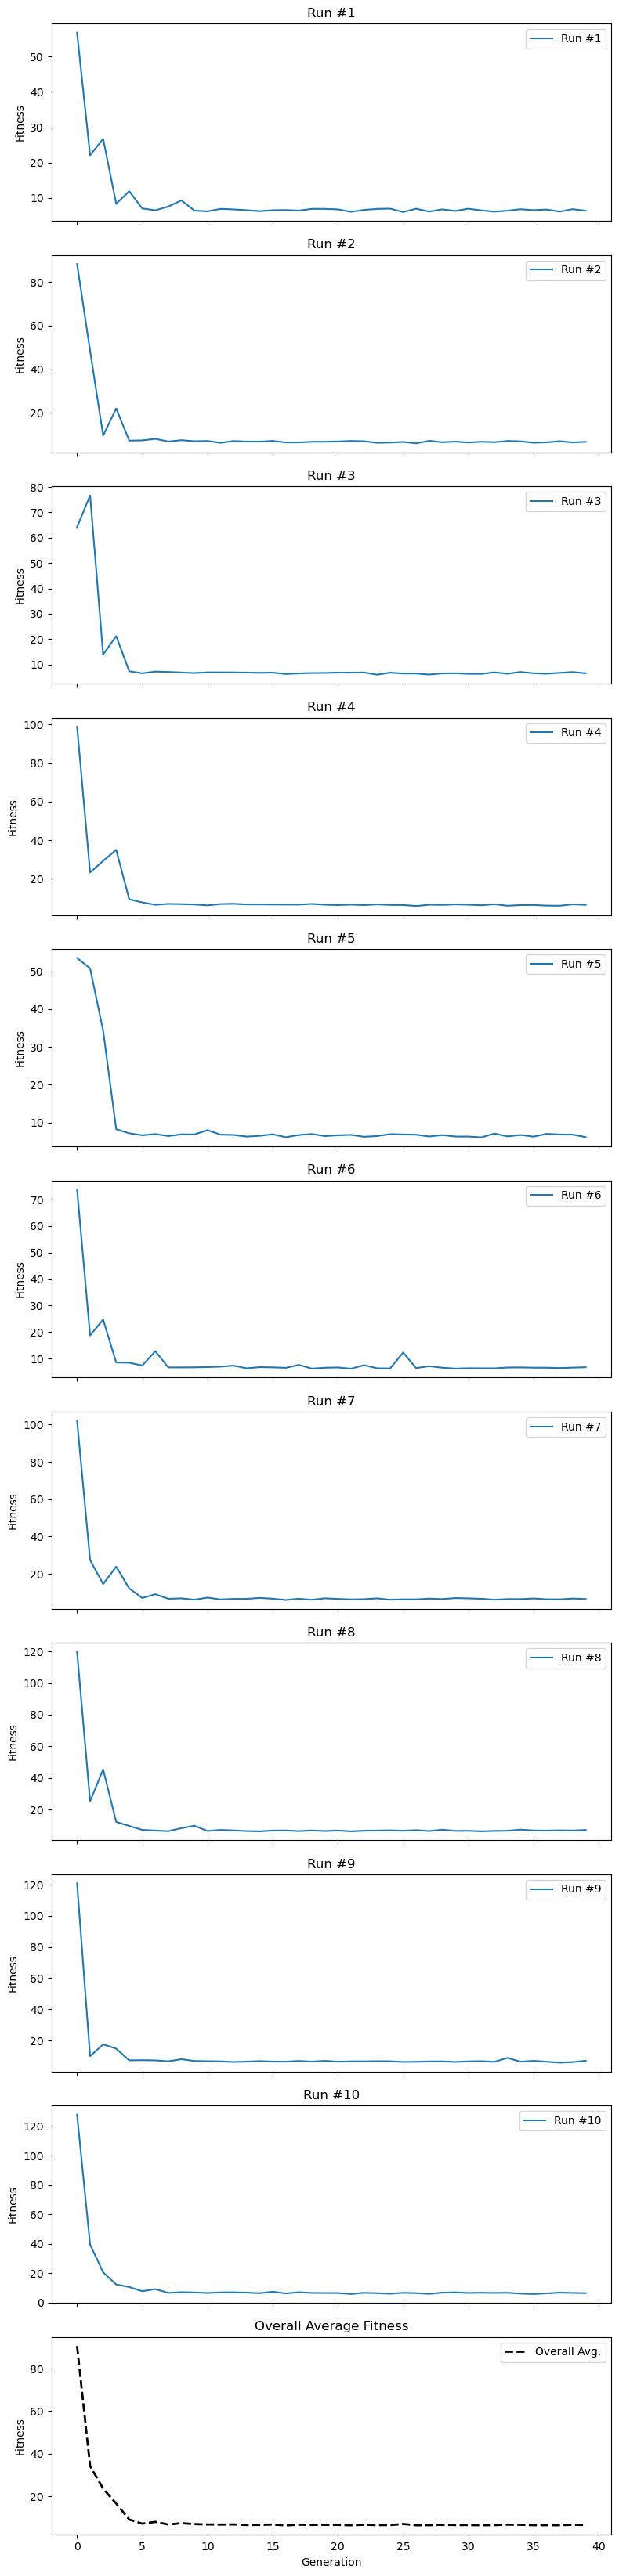

(None,)

In [28]:
genetic_algorithm(parent_selection_func= rank_based_selection,survival_selection_func=truncation_selection),

## Modifying genetic algo for tournament as selection

done need to

# FPS- Tour

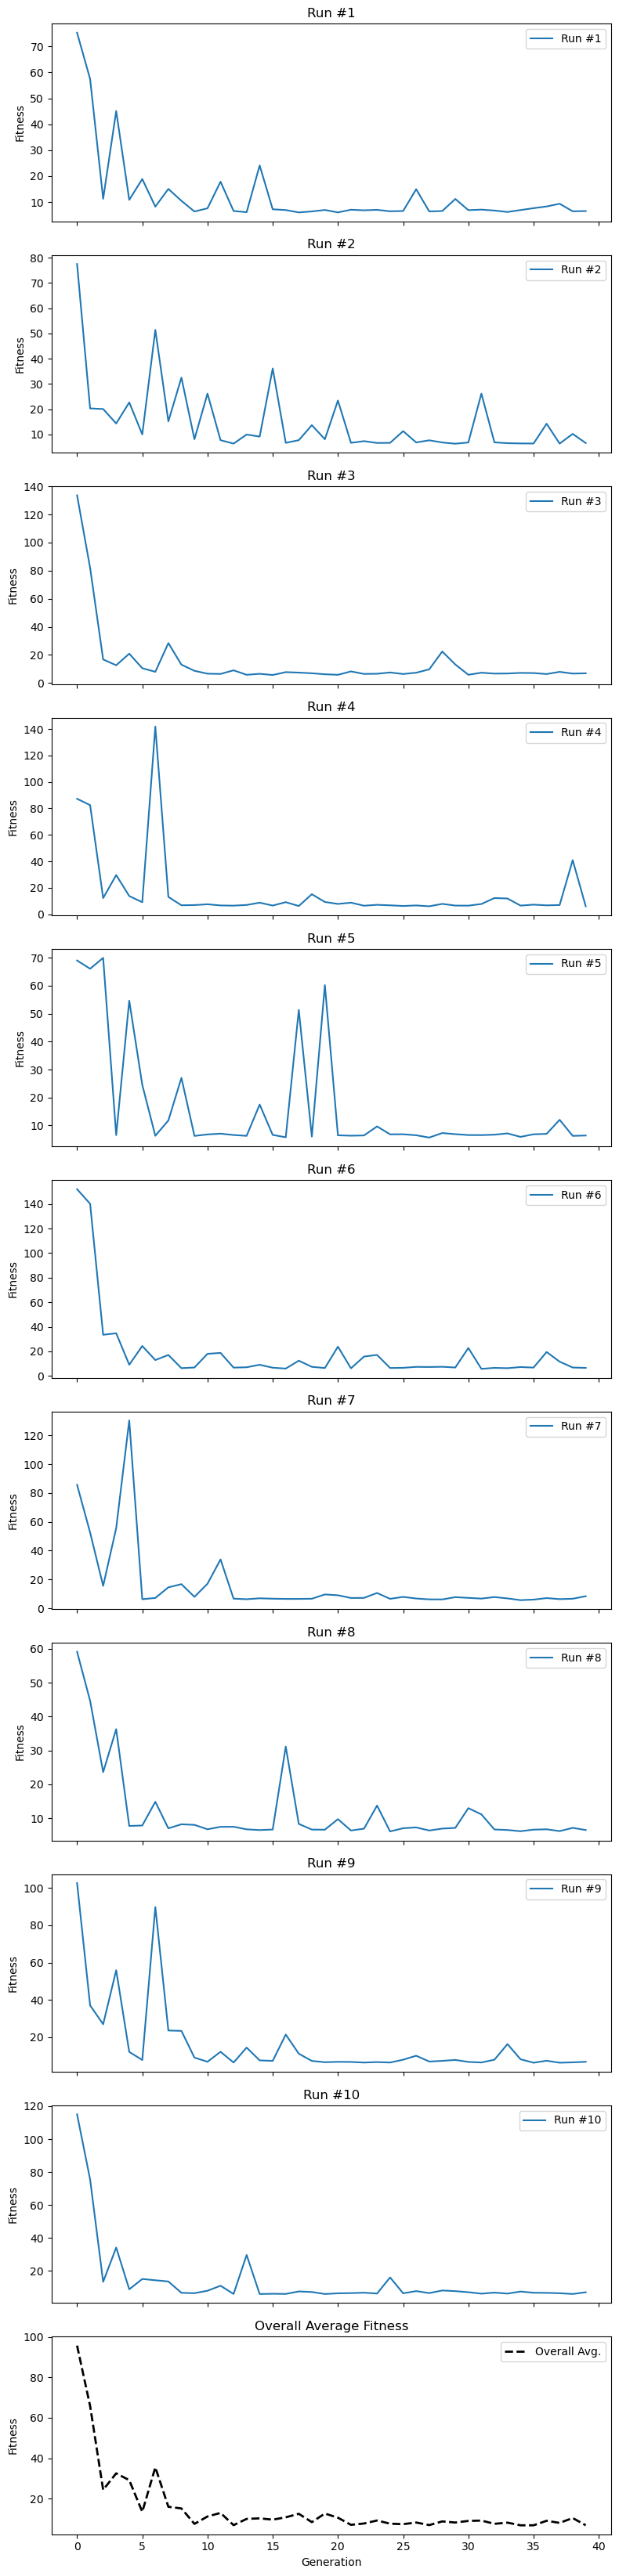

(None,)

In [29]:
genetic_algorithm(parent_selection_func=roulette_wheel_selection, survival_selection_func=tournament_selection_survival),

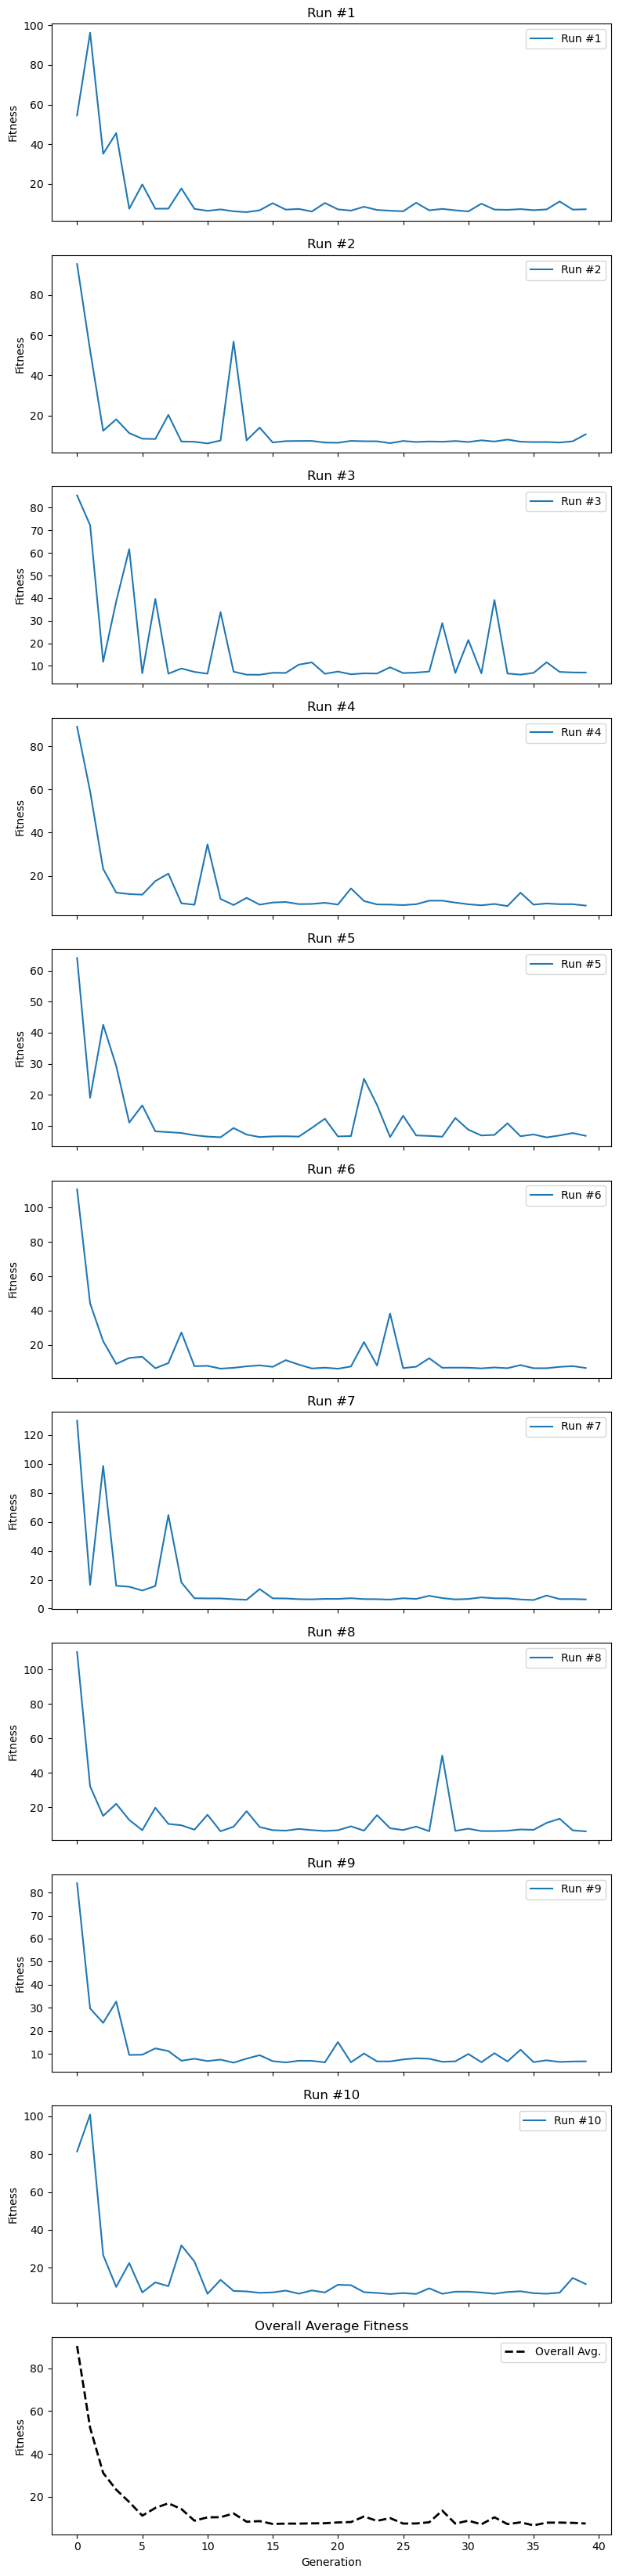

(None,)

In [30]:
genetic_algorithm(parent_selection_func= rank_based_selection,survival_selection_func=tournament_selection_survival),

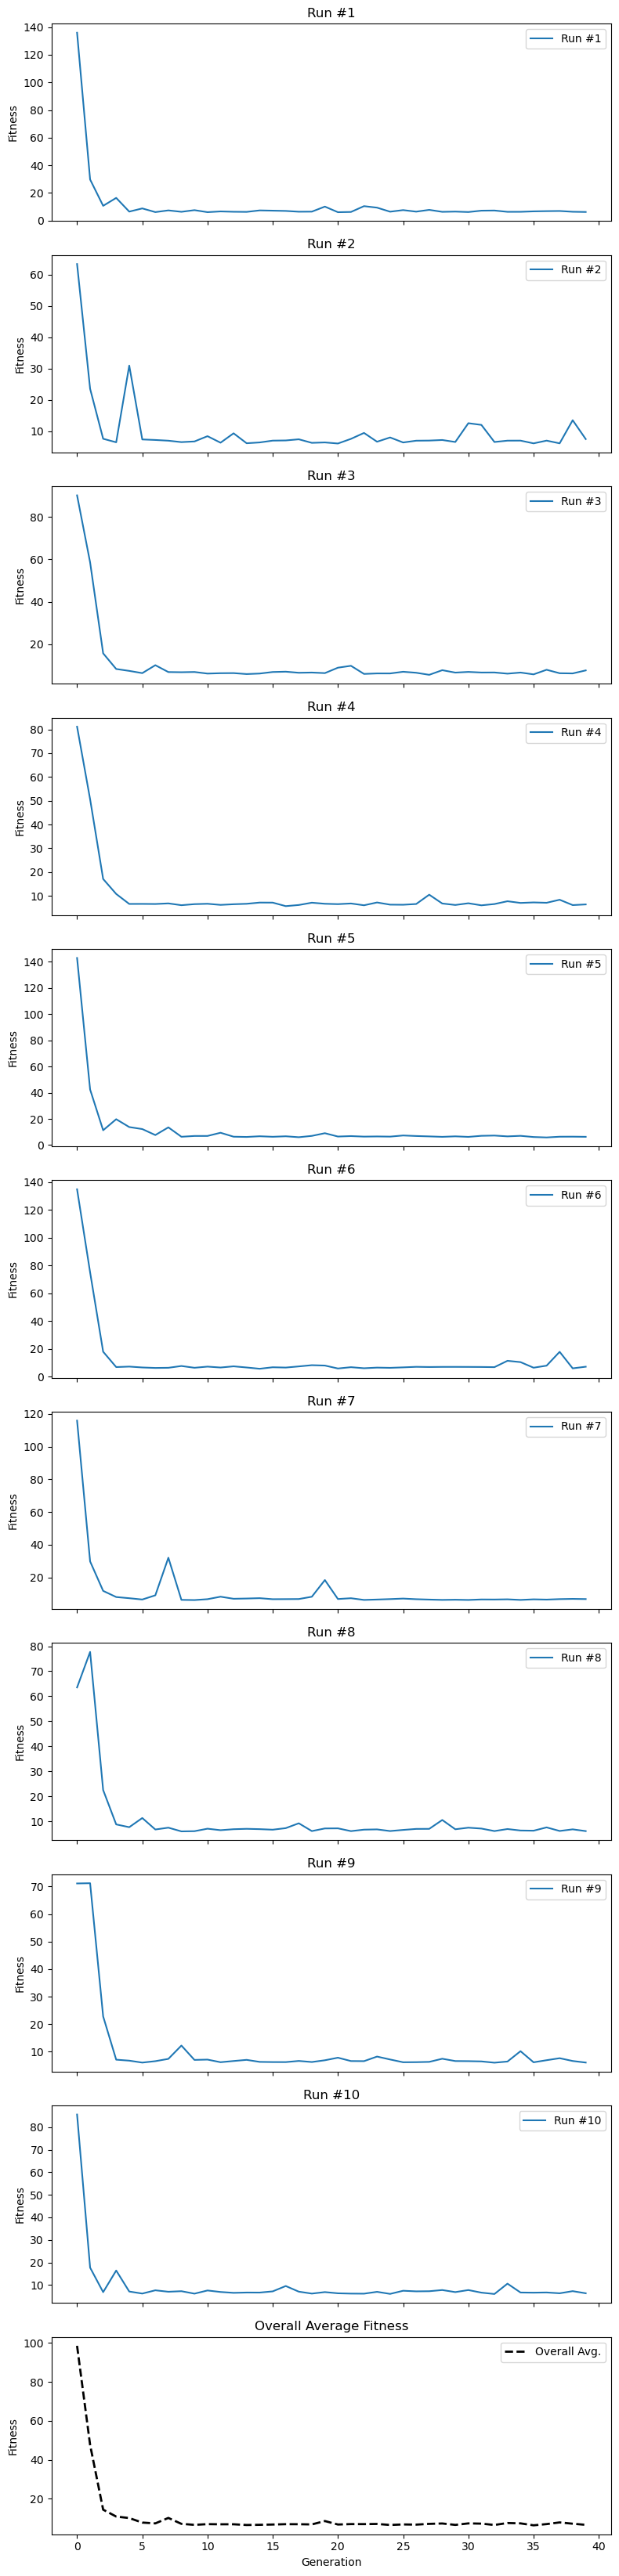

(None,)

In [31]:
genetic_algorithm(parent_selection_func= binary_tournament_selection,survival_selection_func=tournament_selection_survival),

In [ ]:
def genetic_algorithm(generations=40, runs=10, pop_size=10, x1=-5, y1=-5, x2=5, y2=5):
    best_fitness_data = [['Generation'] + [f'Run #{i+1} Best Fit.' for i in range(runs)] + ['Overall Best Fit.']]
    avg_fitness_data = [['Generation'] + [f'Run #{i+1} Avg. Fit.' for i in range(runs)] + ['Overall Avg. Fit.']]
    worst_fitness_data = [['Generation'] + [f'Run #{i+1} Worst Fit.' for i in range(runs)] + ['Overall Worst Fit.']]
    
    for gen in range(generations):
        best_fitness_per_run = []
        avg_fitness_per_run = []
        worst_fitness_per_run = []
        
        for run in range(runs):
            population = initialize_population(pop_size, x1, y1, x2, y2)
            fitnesses = compute_fitness_2(population)
            
            for _ in range(gen):
                new_population = []
                while len(new_population) < pop_size:
                    p1, p2 = binary_tournament_selection(population, fitnesses), binary_tournament_selection(population, fitnesses)
                    c1, c2 = crossover(p1, p2)
                    new_population.append(mutate(c1))
                    new_population.append(mutate(c2))
                
                fitnesses += compute_fitness_2(new_population)
                population += new_population
                population = truncation_selection(population, fitnesses, pop_size)
                fitnesses = compute_fitness(population)
            
            best_fitness_per_run.append(min(fitnesses))
            avg_fitness_per_run.append(np.mean(fitnesses))
            worst_fitness_per_run.append(max(fitnesses))
        
        overall_best_fitness = np.min(best_fitness_per_run)
        overall_avg_fitness = np.mean(avg_fitness_per_run)
        overall_worst_fitness = np.max(worst_fitness_per_run)
        
        best_fitness_data.append([gen + 1] + best_fitness_per_run + [overall_best_fitness])
        avg_fitness_data.append([gen + 1] + avg_fitness_per_run + [overall_avg_fitness])
        worst_fitness_data.append([gen + 1] + worst_fitness_per_run + [overall_worst_fitness])
    
    current_time = time.strftime('%Y-%m-%d_%H-%M-%S')
    
    with open(f'best_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(best_fitness_data)
    
    with open(f'avg_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(avg_fitness_data)
    
    with open(f'worst_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(worst_fitness_data)
    
    # Create subplots with runs + 1 (extra for overall avg)
    fig, axes = plt.subplots(runs + 1, 1, figsize=(8, (runs + 1) * 3), sharex=True)

    # Plot each run in its own subplot
    for i in range(1, runs + 1):
        ax = axes[i - 1]  # Select subplot for the current run
        ax.plot([row[i] for row in avg_fitness_data[1:]], label=f'Run #{i}')
        ax.legend()
        ax.set_ylabel('Fitness')
        ax.set_title(f'Run #{i}')

    # Plot overall average in the last subplot (runs + 1th)
    overall_ax = axes[-1]  # The last subplot is reserved for the overall average
    overall_ax.plot([row[-1] for row in avg_fitness_data[1:]], label='Overall Avg.', linestyle='dashed', linewidth=2, color='black')
    overall_ax.legend()
    overall_ax.set_ylabel('Fitness')
    overall_ax.set_title('Overall Average Fitness')

    # Set common x-label
    plt.xlabel('Generation')

    # Improve layout
    plt.tight_layout()

    # Save and show the plot
    plt.savefig(f'fitness_plot_{current_time}.png')
    plt.show()
# Tournament-Truncation Eq1
genetic_algorithm()
# Final Geneatic algo for final folders data
def genetic_algorithm(
    generations=40,
    runs=10,
    pop_size=10,
    x1=-5,
    y1=-5,
    x2=5,
    y2=5,
    parent_selection_func=roulette_wheel_selection,
    survival_selection_func=truncation_selection,
):
    best_fitness_data = [['Generation'] + [f'Run #{i+1} Best Fit.' for i in range(runs)] + ['Overall Best Fit.']]
    avg_fitness_data = [['Generation'] + [f'Run #{i+1} Avg. Fit.' for i in range(runs)] + ['Overall Avg. Fit.']]
    worst_fitness_data = [['Generation'] + [f'Run #{i+1} Worst Fit.' for i in range(runs)] + ['Overall Worst Fit.']]
    
    for gen in range(generations):
        best_fitness_per_run = []
        avg_fitness_per_run = []
        worst_fitness_per_run = []
        
        for run in range(runs):
            population = initialize_population(pop_size, x1, y1, x2, y2)
            fitnesses = compute_fitness_2(population)
            
            for _ in range(gen):
                new_population = []
                while len(new_population) < pop_size:
                    p1 = parent_selection_func(population, fitnesses)
                    p2 = parent_selection_func(population, fitnesses)
                    c1, c2 = crossover(p1, p2)
                    new_population.append(mutate(c1))
                    new_population.append(mutate(c2))
                
                fitnesses += compute_fitness(new_population)
                population += new_population
                population = survival_selection_func(population, fitnesses, pop_size)
                fitnesses = compute_fitness_2(population)
            
            best_fitness_per_run.append(min(fitnesses))
            avg_fitness_per_run.append(np.mean(fitnesses))
            worst_fitness_per_run.append(max(fitnesses))
        
        overall_best_fitness = np.min(best_fitness_per_run)
        overall_avg_fitness = np.mean(avg_fitness_per_run)
        overall_worst_fitness = np.max(worst_fitness_per_run)
        
        best_fitness_data.append([gen + 1] + best_fitness_per_run + [overall_best_fitness])
        avg_fitness_data.append([gen + 1] + avg_fitness_per_run + [overall_avg_fitness])
        worst_fitness_data.append([gen + 1] + worst_fitness_per_run + [overall_worst_fitness])
    
    current_time = time.strftime('%Y-%m-%d_%H-%M-%S')
    
    with open(f'best_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(best_fitness_data)
    
    with open(f'avg_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(avg_fitness_data)
    
    with open(f'worst_fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(worst_fitness_data)
    
    fig, axes = plt.subplots(runs + 1, 1, figsize=(8, (runs + 1) * 3), sharex=True)
    
    for i in range(1, runs + 1):
        ax = axes[i - 1]
        ax.plot([row[i] for row in avg_fitness_data[1:]], label=f'Run #{i}')
        ax.legend()
        ax.set_ylabel('Fitness')
        ax.set_title(f'Run #{i}')
    
    overall_ax = axes[-1]
    overall_ax.plot([row[-1] for row in avg_fitness_data[1:]], label='Overall Avg.', linestyle='dashed', linewidth=2, color='black')
    overall_ax.legend()
    overall_ax.set_ylabel('Fitness')
    overall_ax.set_title('Overall Average Fitness')
    
    plt.xlabel('Generation')
    plt.tight_layout()
    plt.savefig(f'fitness_plot_{current_time}.png')
    plt.show()
# FPS-Truncation
genetic_algorithm()
# RBS-Trunc
genetic_algorithm(parent_selection_func= rank_based_selection,survival_selection_func=truncation_selection),
## Modifying genetic algo for tournament as selection
def tournament_selection_survival(population, fitnesses, pop_size, tournament_size=2):
    """Perform tournament selection to choose the next generation."""
    new_population = []
    for _ in range(pop_size):
        selected_indices = np.random.choice(len(population), tournament_size, replace=False)
        best_index = selected_indices[np.argmin([fitnesses[i] for i in selected_indices])]  # Minimize fitness
        new_population.append(population[best_index])
    return new_population

# FPS- Tour
genetic_algorithm(parent_selection_func=roulette_wheel_selection, survival_selection_func=tournament_selection_survival),
genetic_algorithm(parent_selection_func= rank_based_selection,survival_selection_func=tournament_selection_survival),
genetic_algorithm(parent_selection_func= binary_tournament_selection,survival_selection_func=tournament_selection_survival),


In [15]:
def fitness_function_2(x, y):
    return 100 * (x**2 - y)**2 + (1 - x)**2

In [17]:
def compute_fitness_2(population):
    return [fitness_function_2(x, y) for x, y in population]

In [ ]:
def genetic_algorithm_2(generations=40, runs=10, pop_size=10):
    best_fitness_history = []
    avg_fitness_history = []
    worst_fitness_history = []
    
    for run in range(runs):
        population = initialize_population(pop_size, -5, -5, 5, 5)
        for gen in range(generations):
            fitnesses = compute_fitness_2(population)
            new_population = []
            
            while len(new_population) < pop_size:
                p1, p2 = binary_tournament_selection(population, fitnesses), binary_tournament_selection(population, fitnesses)
                c1, c2 = crossover(p1, p2)
                new_population.append(mutate(c1))
                new_population.append(mutate(c2))
            
            fitnesses += compute_fitness(new_population)
            population += new_population
            population = truncation_selection(population, fitnesses, pop_size)
            fitnesses = compute_fitness(population)
            
            best_fitness_history.append(min(fitnesses))
            avg_fitness_history.append(np.mean(fitnesses))
            worst_fitness_history.append(max(fitnesses))

    current_time = time.strftime('%Y-%m-%d_%H-%M-%S')
    
    with open(f'fitness_data_{current_time}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Generation', 'Best Fitness', 'Avg Fitness', 'Worst Fitness'])
        for i in range(len(best_fitness_history)):
            writer.writerow([i, best_fitness_history[i], avg_fitness_history[i], worst_fitness_history[i]])
    
    plt.plot(best_fitness_history, label='Best Fitness')
    plt.plot(avg_fitness_history, label='Avg Fitness')
    plt.plot(worst_fitness_history, label='Worst Fitness')
    plt.legend()
    plt.savefig(f'fitness_plot_{current_time}.png')
    plt.show()

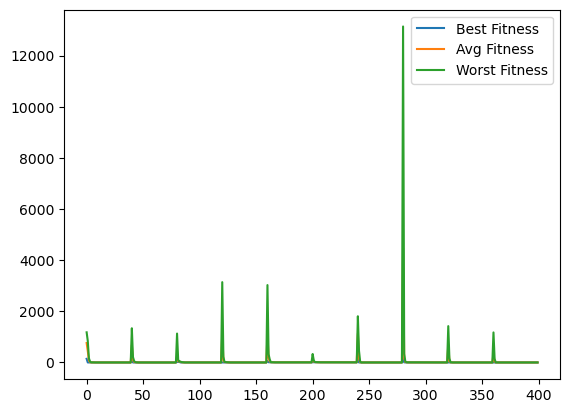

In [19]:
genetic_algorithm_2()

In [38]:
def genetic_algorithm(parent_selection, survival_selection, fitness_function, generations=40, runs=10, pop_size=10, label="experiment"):
    best_fitness_history = []
    avg_fitness_history = []
    worst_fitness_history = []
    
    for run in range(runs):
        population = initialize_population(pop_size)
        for gen in range(generations):
            fitnesses = compute_fitness(population, fitness_function)
            new_population = []
            
            while len(new_population) < pop_size:
                p1, p2 = parent_selection(population, fitnesses), parent_selection(population, fitnesses)
                c1, c2 = crossover(p1, p2)
                new_population.append(mutate(c1))
                new_population.append(mutate(c2))
            
            fitnesses += compute_fitness(new_population, fitness_function)
            population += new_population
            population = survival_selection(population, fitnesses, pop_size)
            fitnesses = compute_fitness(population, fitness_function)
            
            best_fitness_history.append(min(fitnesses))
            avg_fitness_history.append(np.mean(fitnesses))
            worst_fitness_history.append(max(fitnesses))
    
    filename = f'fitness_data_{label}.csv'
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Generation', 'Best Fitness', 'Avg Fitness', 'Worst Fitness'])
        for i in range(len(best_fitness_history)):
            writer.writerow([i, best_fitness_history[i], avg_fitness_history[i], worst_fitness_history[i]])
    
    plt.figure()
    plt.plot(best_fitness_history, label=f'Best Fitness ({label})')
    plt.plot(avg_fitness_history, label=f'Avg Fitness ({label})')
    plt.plot(worst_fitness_history, label=f'Worst Fitness ({label})')
    plt.title(f'Fitness Progression - {label}')
    plt.legend()
    plt.savefig(f'fitness_plot_{label}.png')
    plt.show()

In [31]:
def rank_based_selection(population, fitnesses):
    ranks = np.argsort(np.argsort(fitnesses))
    selection_probs = ranks / sum(ranks)
    return population[np.random.choice(len(population), p=selection_probs)]

In [28]:
def compute_fitness(population, fitness_function):
    return [fitness_function(x, y) for x, y in population]

In [36]:
def binary_tournament_selection(population, fitnesses):
    i1, i2 = random.sample(range(len(population)), 2)
    return population[i1] if fitnesses[i1] < fitnesses[i2] else population[i2]

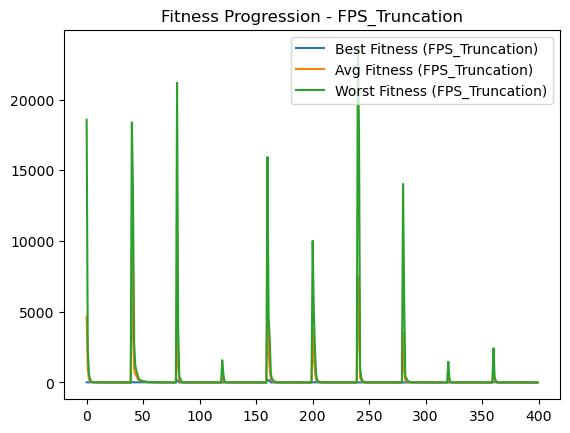

In [29]:
genetic_algorithm(roulette_wheel_selection, truncation_selection, fitness_function, label="FPS_Truncation")

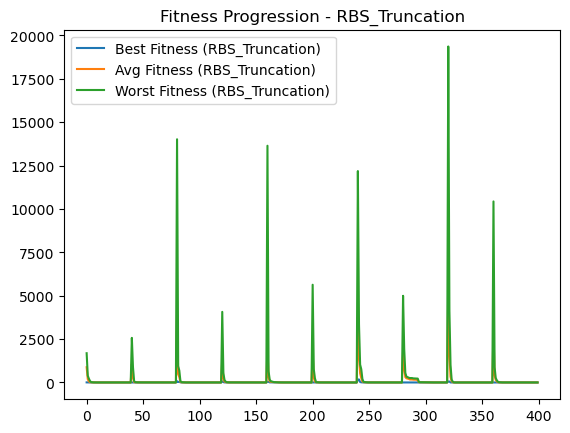

In [30]:
genetic_algorithm(rank_based_selection, truncation_selection, fitness_function, label="RBS_Truncation")

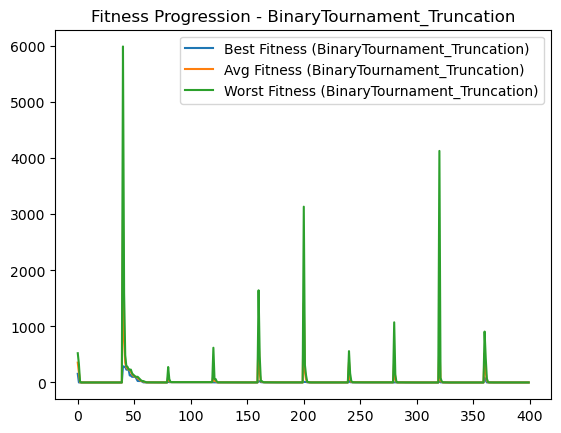

In [31]:
genetic_algorithm(binary_tournament_selection, truncation_selection, fitness_function, label="BinaryTournament_Truncation")

In [39]:
genetic_algorithm(roulette_wheel_selection, binary_tournament_selection, fitness_function, label="FPS_BinaryTournament")

TypeError: binary_tournament_selection() takes 2 positional arguments but 3 were given

In [33]:
genetic_algorithm(rank_based_selection, binary_tournament_selection, fitness_function, label="RBS_BinaryTournament")

TypeError: binary_tournament_selection() takes 2 positional arguments but 3 were given

In [34]:
genetic_algorithm(binary_tournament_selection, binary_tournament_selection, fitness_function, label="BinaryTournament_BinaryTournament")

TypeError: binary_tournament_selection() takes 2 positional arguments but 3 were given

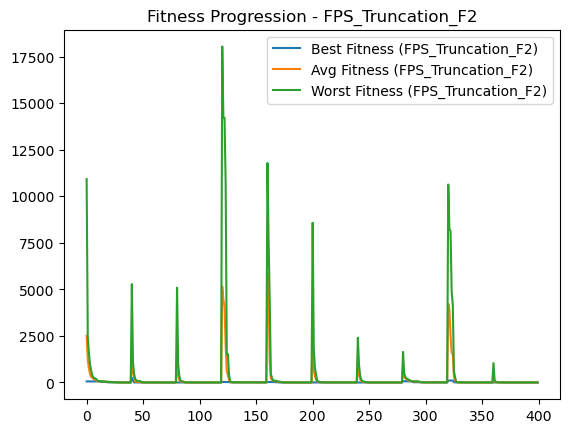

In [35]:
genetic_algorithm(roulette_wheel_selection, truncation_selection, fitness_function_2, label="FPS_Truncation_F2")

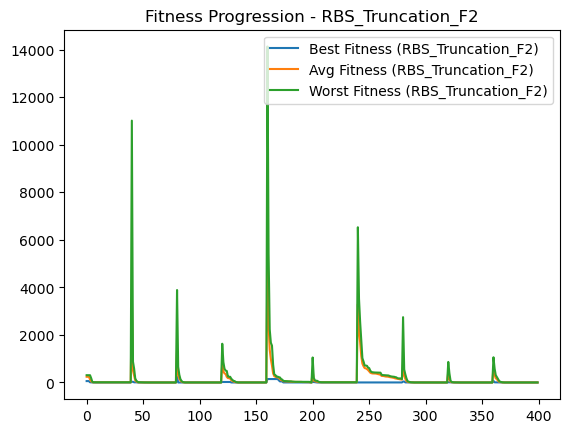

In [40]:
genetic_algorithm(rank_based_selection, truncation_selection, fitness_function_2, label="RBS_Truncation_F2")

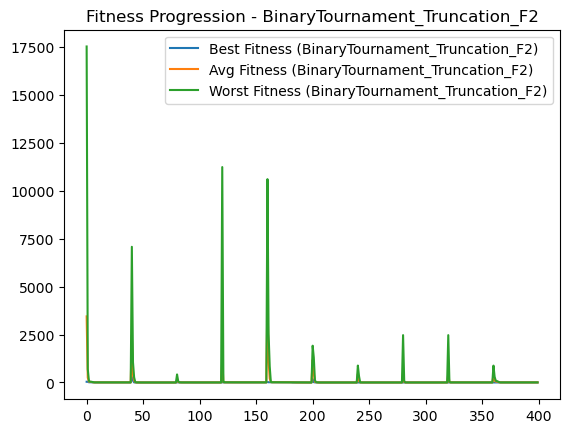

In [41]:
genetic_algorithm(binary_tournament_selection, truncation_selection, fitness_function_2, label="BinaryTournament_Truncation_F2")

In [42]:
genetic_algorithm(roulette_wheel_selection, binary_tournament_selection, fitness_function_2, label="FPS_BinaryTournament_F2")

TypeError: binary_tournament_selection() takes 2 positional arguments but 3 were given

In [43]:
genetic_algorithm(rank_based_selection, binary_tournament_selection, fitness_function_2, label="RBS_BinaryTournament_F2")

TypeError: binary_tournament_selection() takes 2 positional arguments but 3 were given

In [44]:
genetic_algorithm(binary_tournament_selection, binary_tournament_selection, fitness_function_2, label="BinaryTournament_BinaryTournament_F2")

TypeError: binary_tournament_selection() takes 2 positional arguments but 3 were given